In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader, Subset
from torchvision.models import resnet18, mobilenet_v2, squeezenet1_1
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
from collections import Counter

### Data and visualisation

In [65]:
# Load and Describe Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Extract labels from the dataset
train_labels = [train_dataset.classes[label] for _, label in train_dataset]
test_labels = [test_dataset.classes[label] for _, label in test_dataset]

# Get unique class labels and sort them for consistency
unique_classes = sorted(set(train_labels + test_labels))
num_classes = len(unique_classes)

# Count the occurrences of each class in the training and test sets
train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

# Ensure each class has a count (fill missing classes with 0)
train_class_counts = [train_counts.get(cls, 0) for cls in unique_classes]
test_class_counts = [test_counts.get(cls, 0) for cls in unique_classes]

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")



Files already downloaded and verified
Files already downloaded and verified
Training dataset size: 50000 samples
Test dataset size: 10000 samples


In [3]:
# Split the training dataset into 80% training and 20% validation
train_indices, val_indices = train_test_split(
    range(len(train_dataset)),
    test_size=0.2,
    stratify=[label for _, label in train_dataset],
    random_state=42
)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

# Extract labels from the dataset
train_labels = [train_dataset.classes[label] for _, label in train_subset]
val_labels = [train_dataset.classes[label] for _, label in val_subset]

# Get unique class labels and sort them for consistency
unique_classes = sorted(set(train_labels + val_labels + test_labels))
num_classes = len(unique_classes)

# Count the occurrences of each class in the training, validation, and test sets
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

# Ensure each class has a count (fill missing classes with 0)
train_class_counts = [train_counts.get(cls, 0) for cls in unique_classes]
val_class_counts = [val_counts.get(cls, 0) for cls in unique_classes]


Training dataset size: 40000 samples
Validation dataset size: 10000 samples
Test dataset size: 10000 samples


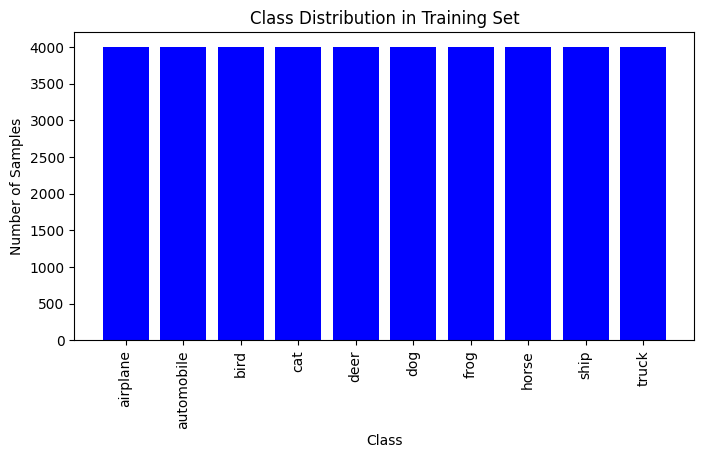

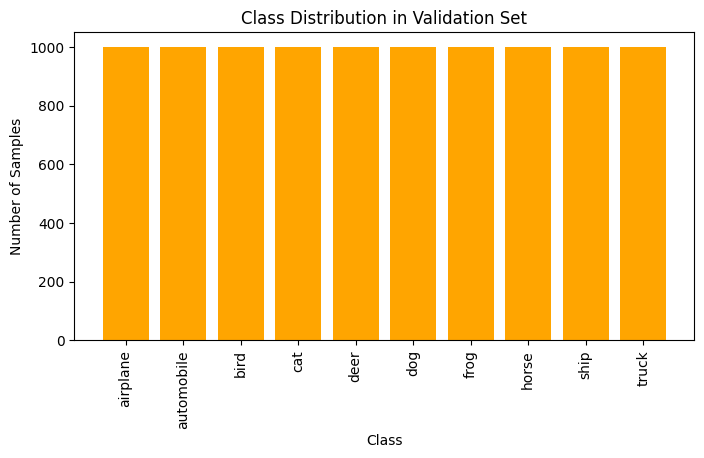

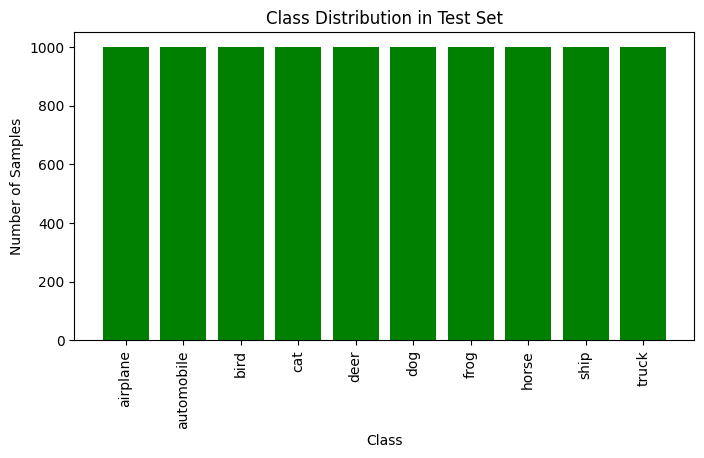

In [4]:
# Print dataset sizes
print(f"Training dataset size: {len(train_subset)} samples")
print(f"Validation dataset size: {len(val_subset)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")

# Plot the distribution for the training set
plt.figure(figsize=(8, 4))
plt.bar(unique_classes, train_class_counts, color='blue')
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()

# Plot the distribution for the validation set
plt.figure(figsize=(8, 4))
plt.bar(unique_classes, val_class_counts, color='orange')
plt.title("Class Distribution in Validation Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()

# Plot the distribution for the test set
plt.figure(figsize=(8, 4))
plt.bar(unique_classes, test_class_counts, color='green')
plt.title("Class Distribution in Test Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()

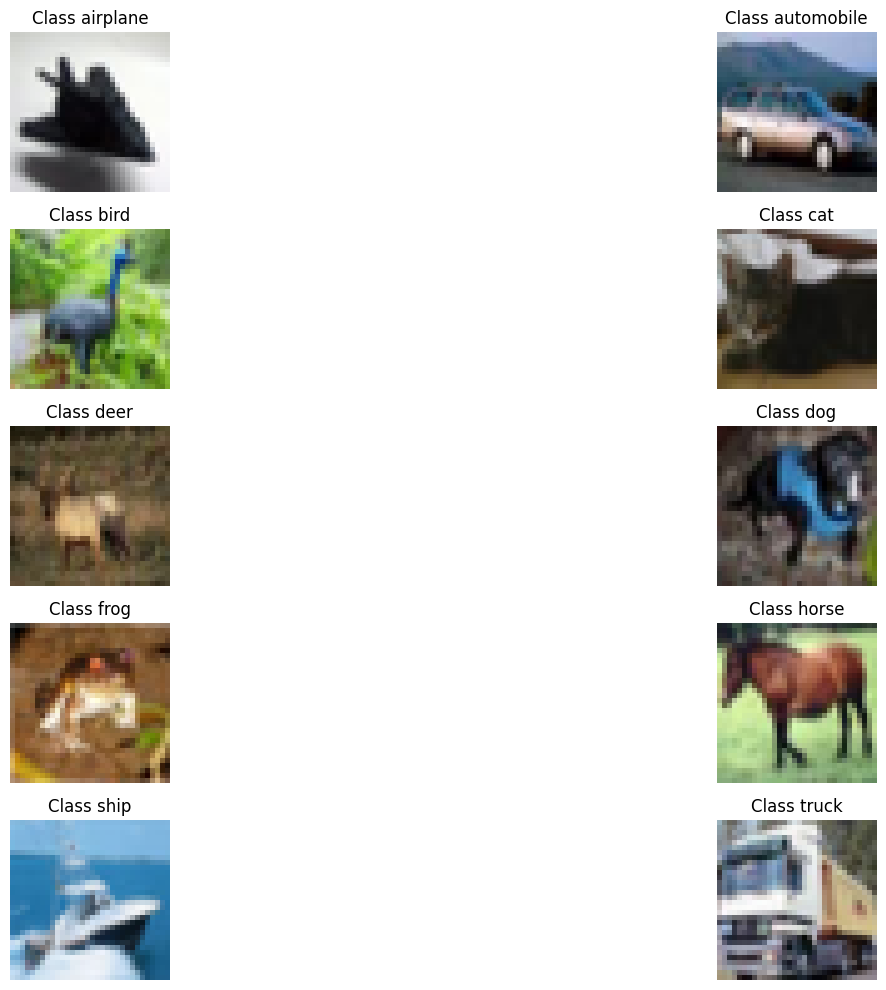

In [66]:
# Visualize sample images for each class
class_samples = {}

# Iterate through the training dataset and select one sample for each class
for img, label in train_dataset:
    class_name = train_dataset.classes[label]
    if class_name not in class_samples:
        class_samples[class_name] = img

    # Break the loop if we already have one sample for each class
    if len(class_samples) == num_classes:
        break

# Plot the sample images for each class
plt.figure(figsize=(20, 10))
for i, cls in enumerate(unique_classes):
    if cls in class_samples:
        img = class_samples[cls]
        img = img / 2 + 0.5  # Unnormalize the image
        np_img = img.numpy()
        np_img = np.transpose(np_img, (1, 2, 0))  # Rearrange dimensions for plotting

        plt.subplot(5, 2, i + 1)  # Create subplots (2 rows, 5 columns)
        plt.imshow(np_img)
        plt.title(f"Class {cls}")
        plt.axis('off')

plt.tight_layout()
plt.show()



### ResNet-18 Model Architecture

In [6]:
# Define ResNet-18 Model Architecture

# Basic Block for ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # If the input and output channels don't match, use a shortcut with a convolution
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet18 Architecture
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        # Initial layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)  # First block may have stride != 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



### Defining some trainings function

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Define training model function
def train_model(model, train_dataset, val_dataset, optimizer=optim.Adam, lr=0.001, epoch_num=100, patience=10, model_name="model_name", 
                regularization_type=None, regularization_strength=None):

    optimizer = optimizer(model.parameters(), lr=lr)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float("inf")
    patience_counter = 0
    epochs = epoch_num
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for inputs, labels in tqdm(train_dataset, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Apply regularization if specified
            if regularization_type == "l1":
                l1_reg = sum(param.abs().sum() for param in model.parameters())
                loss += regularization_strength * l1_reg
            elif regularization_type == "l2":
                l2_reg = sum(param.pow(2).sum() for param in model.parameters())
                loss += regularization_strength * l2_reg
            elif regularization_type == "l1_l2":
                l1_reg = sum(param.abs().sum() for param in model.parameters())
                l2_reg = sum(param.pow(2).sum() for param in model.parameters())
                loss += regularization_strength * (l1_reg + l2_reg)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate training accuracy
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= len(train_dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Apply regularization if specified
                if regularization_type == "l1":
                    l1_reg = sum(param.abs().sum() for param in model.parameters())
                    loss += regularization_strength * l1_reg
                elif regularization_type == "l2":
                    l2_reg = sum(param.pow(2).sum() for param in model.parameters())
                    loss += regularization_strength * l2_reg
                elif regularization_type == "l1_l2":
                    l1_reg = sum(param.abs().sum() for param in model.parameters())
                    l2_reg = sum(param.pow(2).sum() for param in model.parameters())
                    loss += regularization_strength * (l1_reg + l2_reg)

                val_loss += loss.item()

                # Calculate validation accuracy
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print results per epoch
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping...")
                break

    # Save the final model at the end of training
    save_path = f"models/{model_name}.pth"  # Define the save path with the custom name
    torch.save(model.state_dict(), save_path)
    print(f"Training complete. Final model saved at '{save_path}'")

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [20]:
def plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name):
    plt.figure(figsize=(14, 5))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"{model_name} - Loss Curves ")
    plt.legend()

    # Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"{model_name} - Accuracy Curves")
    plt.legend()

    # Display the plots
    plt.show()



In [21]:
# Confusion Matrix Evaluation Function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Plot Confusion Matrix with Adjustable Size
def plot_confusion_matrix(y_true, y_pred, classes, figsize=(10, 10), model_name=model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    # Adjust figure size
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.xticks(rotation=45)
    plt.title(f"{model_name} - Confusion Matrix ")
    plt.show()



### Resnet18 Base Model

In [22]:
# Hyperparameter tuning
model = ResNet18(num_classes=10)
train_dataset = train_loader
val_dataset = val_loader
optimizer=optim.Adam
learning_rate=0.001
epochs =100
patience=10
regularization=None
regularization_strength=None
models = {}
model_name = "Resnet18_base"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)
#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 1.4252, Train Accuracy: 0.4881, Validation Loss: 1.3843, Validation Accuracy: 0.5127


Epoch 2/100, Train Loss: 1.0207, Train Accuracy: 0.6336, Validation Loss: 1.0678, Validation Accuracy: 0.6266


Epoch 3/100, Train Loss: 0.8361, Train Accuracy: 0.7029, Validation Loss: 0.8861, Validation Accuracy: 0.6894


Epoch 4/100, Train Loss: 0.7050, Train Accuracy: 0.7519, Validation Loss: 0.8377, Validation Accuracy: 0.7068


Epoch 5/100, Train Loss: 0.5958, Train Accuracy: 0.7914, Validation Loss: 0.8439, Validation Accuracy: 0.7152


Epoch 6/100, Train Loss: 0.4987, Train Accuracy: 0.8255, Validation Loss: 0.7747, Validation Accuracy: 0.7373


Epoch 7/100, Train Loss: 0.4193, Train Accuracy: 0.8521, Validation Loss: 0.9154, Validation Accuracy: 0.7113


Epoch 8/100, Train Loss: 0.3439, Train Accuracy: 0.8790, Validation Loss: 0.9063, Validation Accuracy: 0.7250


Epoch 9/100, Train Loss: 0.2732, Train Accuracy: 0.9041, Validation Loss: 0.9855, Validation Accuracy: 0.7194


Epoch 10/100, Train Loss: 0.2345, Train Accuracy: 0.9191, Validation Loss: 0.9572, Validation Accuracy: 0.7279


Epoch 11/100, Train Loss: 0.1815, Train Accuracy: 0.9352, Validation Loss: 1.1105, Validation Accuracy: 0.7201


Epoch 12/100, Train Loss: 0.1579, Train Accuracy: 0.9439, Validation Loss: 1.0225, Validation Accuracy: 0.7427


Epoch 13/100, Train Loss: 0.1336, Train Accuracy: 0.9535, Validation Loss: 1.2190, Validation Accuracy: 0.7203


Epoch 14/100, Train Loss: 0.1082, Train Accuracy: 0.9630, Validation Loss: 1.1822, Validation Accuracy: 0.7283


Epoch 15/100, Train Loss: 0.0996, Train Accuracy: 0.9652, Validation Loss: 1.2052, Validation Accuracy: 0.7381


Epoch 16/100, Train Loss: 0.0861, Train Accuracy: 0.9697, Validation Loss: 1.2408, Validation Accuracy: 0.7381
Early stopping...
Training complete. Final model saved at 'models/Resnet18_base.pth'


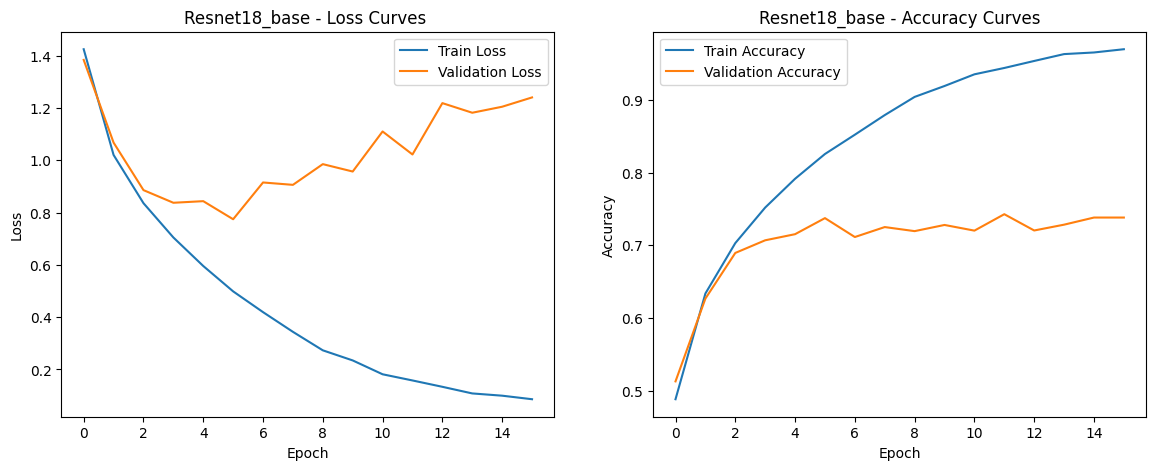

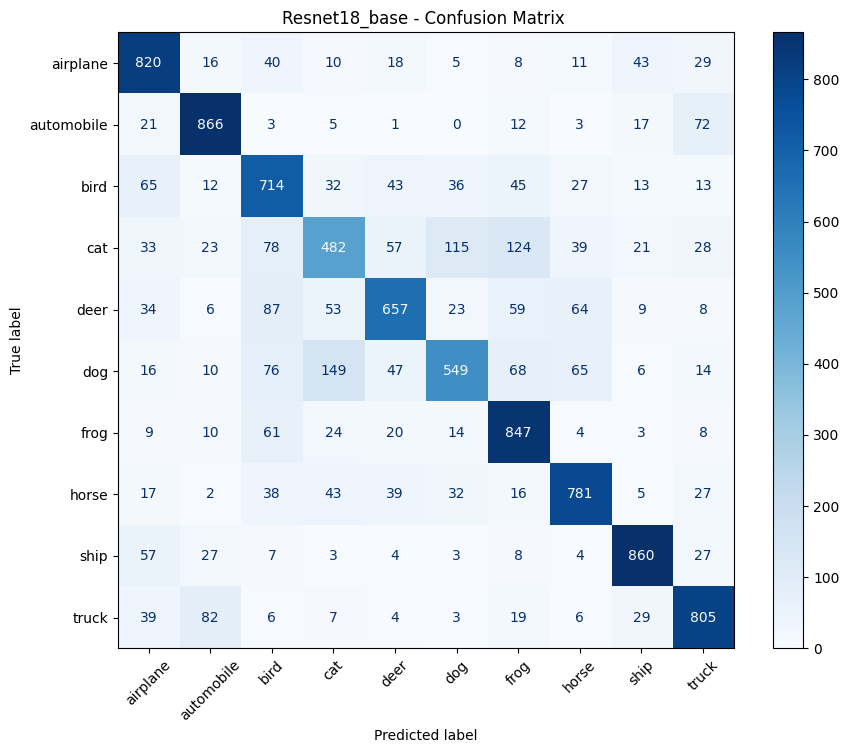

In [23]:
# Loss and accuracy curves 
model_name = "Resnet18_base"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 

## OPTIMISATION

### ResNet18 model optimisation-1

In [24]:
# Hyperparameter tuning
model = ResNet18(num_classes=10)
train_dataset = train_loader
val_dataset = val_loader
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L1"
regularization_strength=0.001
models = {}
model_name = "Resnet18_opt1"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 1.5708, Train Accuracy: 0.4351, Validation Loss: 1.4084, Validation Accuracy: 0.4947


Epoch 2/100, Train Loss: 1.1251, Train Accuracy: 0.5985, Validation Loss: 1.2589, Validation Accuracy: 0.5582


Epoch 3/100, Train Loss: 0.8466, Train Accuracy: 0.7014, Validation Loss: 1.2580, Validation Accuracy: 0.5768


Epoch 4/100, Train Loss: 0.5970, Train Accuracy: 0.7944, Validation Loss: 1.3191, Validation Accuracy: 0.5782


Epoch 5/100, Train Loss: 0.3850, Train Accuracy: 0.8702, Validation Loss: 1.4802, Validation Accuracy: 0.5725


Epoch 6/100, Train Loss: 0.2483, Train Accuracy: 0.9173, Validation Loss: 1.6723, Validation Accuracy: 0.5770


Epoch 7/100, Train Loss: 0.1669, Train Accuracy: 0.9453, Validation Loss: 1.7926, Validation Accuracy: 0.5808


Epoch 8/100, Train Loss: 0.1440, Train Accuracy: 0.9512, Validation Loss: 1.8288, Validation Accuracy: 0.5837


Epoch 9/100, Train Loss: 0.1075, Train Accuracy: 0.9645, Validation Loss: 1.9094, Validation Accuracy: 0.5788


Epoch 10/100, Train Loss: 0.0816, Train Accuracy: 0.9743, Validation Loss: 1.9352, Validation Accuracy: 0.5883


Epoch 11/100, Train Loss: 0.0748, Train Accuracy: 0.9761, Validation Loss: 2.0390, Validation Accuracy: 0.5861


Epoch 12/100, Train Loss: 0.0967, Train Accuracy: 0.9663, Validation Loss: 2.0170, Validation Accuracy: 0.5846


Epoch 13/100, Train Loss: 0.0778, Train Accuracy: 0.9746, Validation Loss: 2.1063, Validation Accuracy: 0.5890
Early stopping...
Training complete. Final model saved at 'models/Resnet18_opt1.pth'


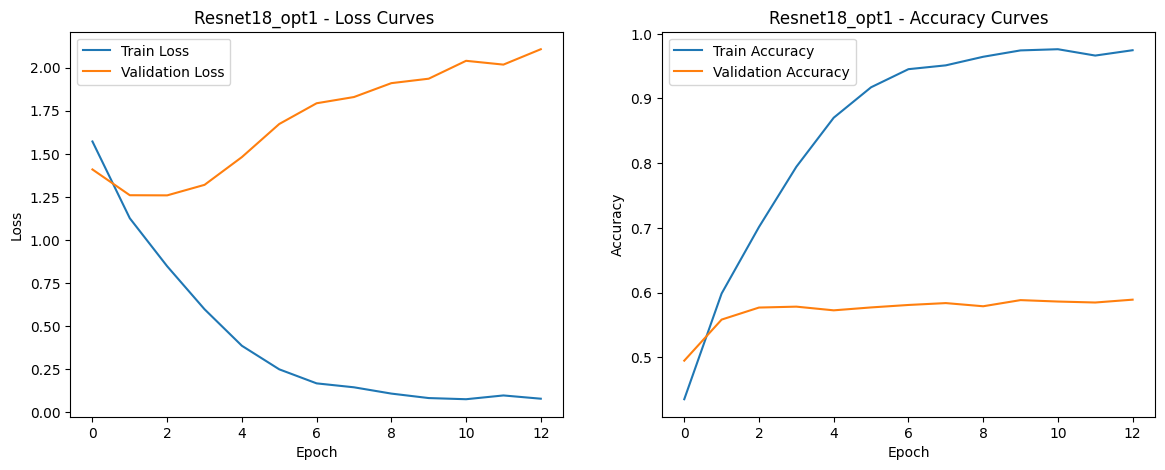

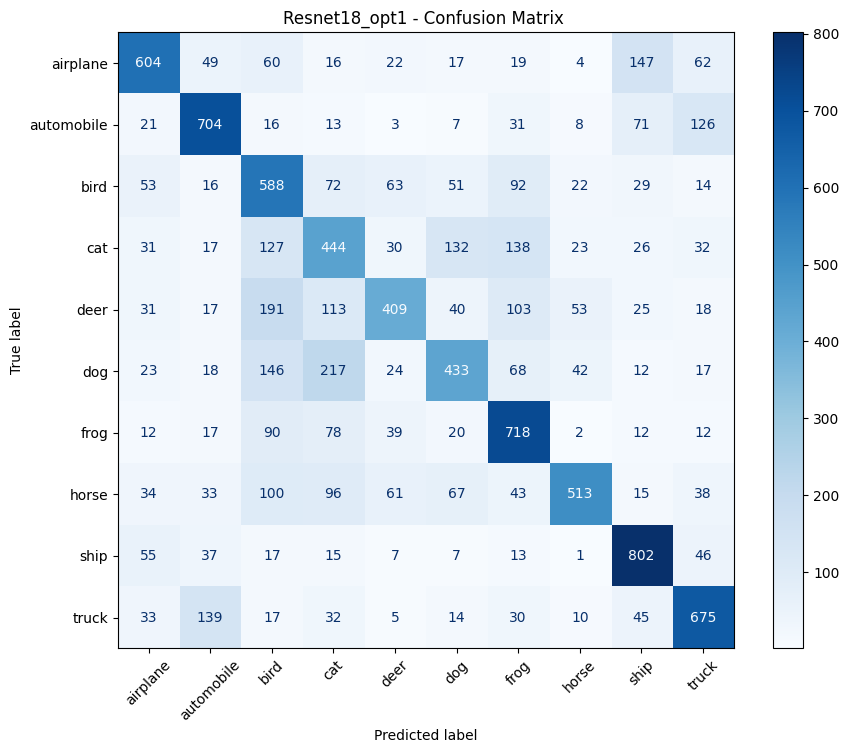

In [25]:
# Loss and accuracy curves 
model_name = "Resnet18_opt1"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 


### ResNet18 model optimisation-2

In [26]:
# Hyperparameter tuning
model = ResNet18(num_classes=10)
train_dataset = train_loader
val_dataset = val_loader
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L2"
regularization_strength=0.0001
models = {}
model_name = "Resnet18_opt2"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 1.5471, Train Accuracy: 0.4412, Validation Loss: 1.3201, Validation Accuracy: 0.5239


Epoch 2/100, Train Loss: 1.1062, Train Accuracy: 0.6078, Validation Loss: 1.2796, Validation Accuracy: 0.5435


Epoch 3/100, Train Loss: 0.8459, Train Accuracy: 0.7010, Validation Loss: 1.2461, Validation Accuracy: 0.5688


Epoch 4/100, Train Loss: 0.5992, Train Accuracy: 0.7949, Validation Loss: 1.3116, Validation Accuracy: 0.5794


Epoch 5/100, Train Loss: 0.3924, Train Accuracy: 0.8673, Validation Loss: 1.4558, Validation Accuracy: 0.5704


Epoch 6/100, Train Loss: 0.2471, Train Accuracy: 0.9160, Validation Loss: 1.7052, Validation Accuracy: 0.5600


Epoch 7/100, Train Loss: 0.1817, Train Accuracy: 0.9389, Validation Loss: 1.7720, Validation Accuracy: 0.5717


Epoch 8/100, Train Loss: 0.1317, Train Accuracy: 0.9565, Validation Loss: 1.8373, Validation Accuracy: 0.5745


Epoch 9/100, Train Loss: 0.1007, Train Accuracy: 0.9672, Validation Loss: 1.9031, Validation Accuracy: 0.5862


Epoch 10/100, Train Loss: 0.0998, Train Accuracy: 0.9667, Validation Loss: 1.9642, Validation Accuracy: 0.5837


Epoch 11/100, Train Loss: 0.1137, Train Accuracy: 0.9618, Validation Loss: 1.9346, Validation Accuracy: 0.5866


Epoch 12/100, Train Loss: 0.1012, Train Accuracy: 0.9653, Validation Loss: 1.9165, Validation Accuracy: 0.5989


Epoch 13/100, Train Loss: 0.0611, Train Accuracy: 0.9804, Validation Loss: 1.9907, Validation Accuracy: 0.5962
Early stopping...
Training complete. Final model saved at 'models/Resnet18_opt2.pth'


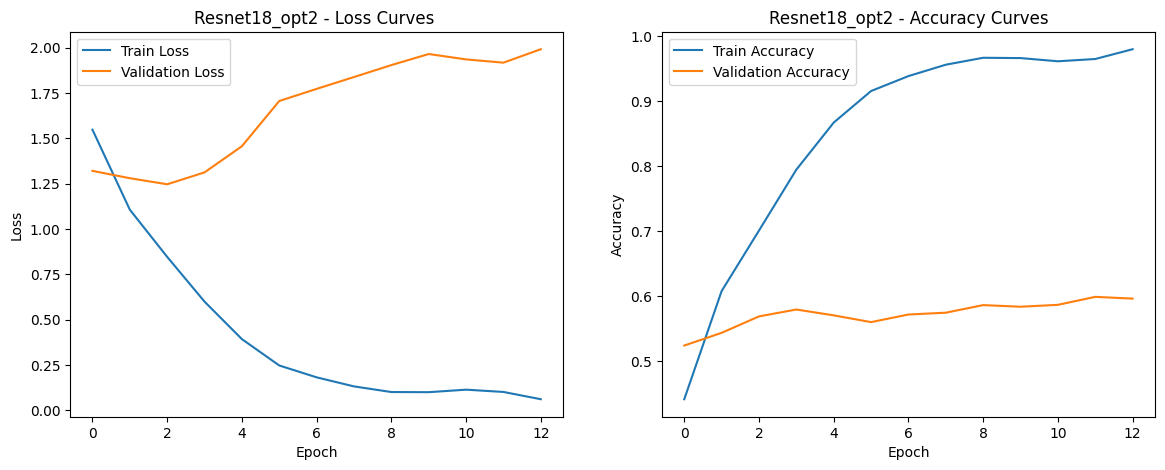

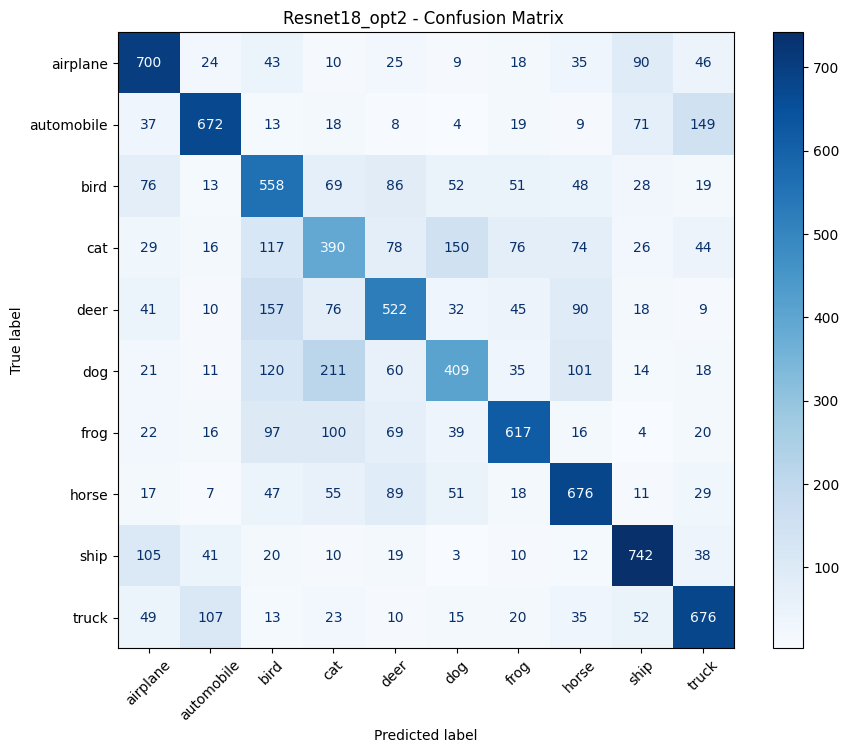

In [27]:
# Loss and accuracy curves 
model_name = "Resnet18_opt2"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 

### ResNet18 model optimisation-3

In [28]:
# Hyperparameter tuning
model = ResNet18(num_classes=10)
train_dataset = train_loader
val_dataset = val_loader
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L1L2"
regularization_strength=0.01
models = {}
model_name = "Resnet18_opt3"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc


Epoch 1/100, Train Loss: 1.5449, Train Accuracy: 0.4441, Validation Loss: 1.3439, Validation Accuracy: 0.5129


Epoch 2/100, Train Loss: 1.1189, Train Accuracy: 0.6006, Validation Loss: 1.2724, Validation Accuracy: 0.5412


Epoch 3/100, Train Loss: 0.8534, Train Accuracy: 0.6999, Validation Loss: 1.3252, Validation Accuracy: 0.5517


Epoch 4/100, Train Loss: 0.6171, Train Accuracy: 0.7848, Validation Loss: 1.3418, Validation Accuracy: 0.5734


Epoch 5/100, Train Loss: 0.4017, Train Accuracy: 0.8627, Validation Loss: 1.5211, Validation Accuracy: 0.5687


Epoch 6/100, Train Loss: 0.2480, Train Accuracy: 0.9168, Validation Loss: 1.5928, Validation Accuracy: 0.5768


Epoch 7/100, Train Loss: 0.1651, Train Accuracy: 0.9468, Validation Loss: 1.7132, Validation Accuracy: 0.5832


Epoch 8/100, Train Loss: 0.1533, Train Accuracy: 0.9488, Validation Loss: 1.8043, Validation Accuracy: 0.5741


Epoch 9/100, Train Loss: 0.1082, Train Accuracy: 0.9643, Validation Loss: 1.9130, Validation Accuracy: 0.5756


Epoch 10/100, Train Loss: 0.0988, Train Accuracy: 0.9678, Validation Loss: 1.9795, Validation Accuracy: 0.5745


Epoch 11/100, Train Loss: 0.0856, Train Accuracy: 0.9717, Validation Loss: 2.0235, Validation Accuracy: 0.5771


Epoch 12/100, Train Loss: 0.0841, Train Accuracy: 0.9720, Validation Loss: 2.1097, Validation Accuracy: 0.5751
Early stopping...
Training complete. Final model saved at 'models/Resnet18_opt3.pth'


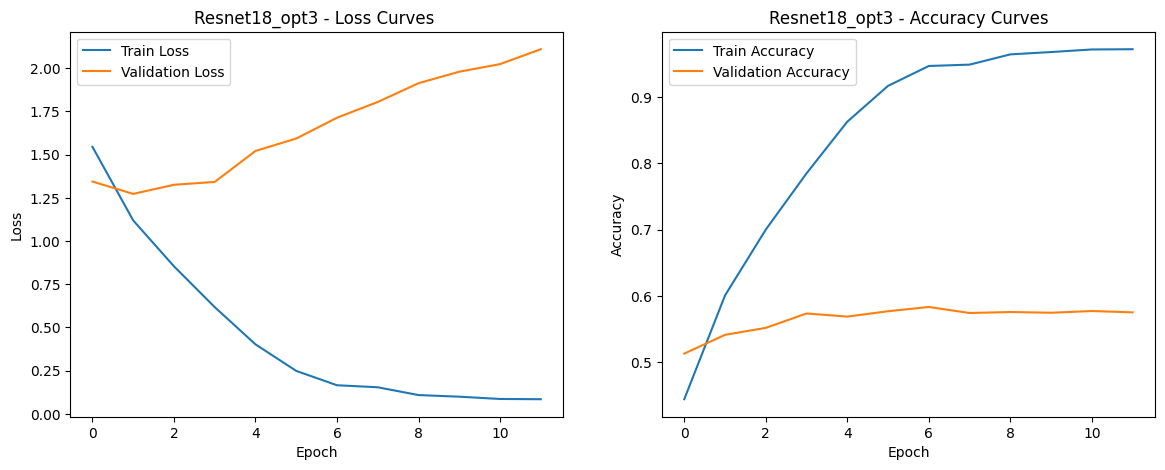

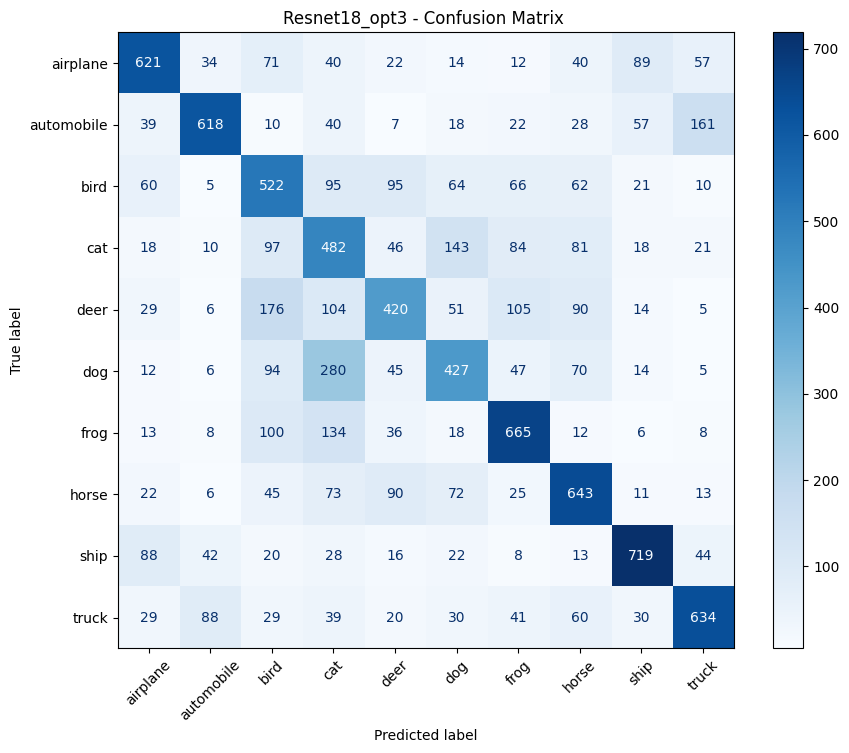

In [29]:
# Loss and accuracy curves 
model_name = "Resnet18_opt3"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 

### ResNet18 model optimisation-4

In [30]:
# Update batch size
train_loader_128 = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=4)
val_loader_128 = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

# Hyperparameter tuning
model = ResNet18(num_classes=10)
train_dataset = train_loader_128
val_dataset = val_loader_128
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L2"
regularization_strength=0.01
models = {}
model_name = "Resnet18_opt4"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc



Epoch 1/100, Train Loss: 1.5112, Train Accuracy: 0.4567, Validation Loss: 1.2777, Validation Accuracy: 0.5438


Epoch 2/100, Train Loss: 1.0951, Train Accuracy: 0.6105, Validation Loss: 1.1640, Validation Accuracy: 0.5854


Epoch 3/100, Train Loss: 0.8547, Train Accuracy: 0.6956, Validation Loss: 1.1240, Validation Accuracy: 0.6065


Epoch 4/100, Train Loss: 0.6583, Train Accuracy: 0.7679, Validation Loss: 1.1245, Validation Accuracy: 0.6190


Epoch 5/100, Train Loss: 0.4747, Train Accuracy: 0.8353, Validation Loss: 1.2466, Validation Accuracy: 0.6193


Epoch 6/100, Train Loss: 0.3462, Train Accuracy: 0.8800, Validation Loss: 1.4574, Validation Accuracy: 0.6038


Epoch 7/100, Train Loss: 0.2410, Train Accuracy: 0.9167, Validation Loss: 1.4967, Validation Accuracy: 0.6067


Epoch 8/100, Train Loss: 0.1838, Train Accuracy: 0.9365, Validation Loss: 1.5828, Validation Accuracy: 0.6204


Epoch 9/100, Train Loss: 0.1567, Train Accuracy: 0.9455, Validation Loss: 1.6286, Validation Accuracy: 0.6253


Epoch 10/100, Train Loss: 0.1359, Train Accuracy: 0.9533, Validation Loss: 1.6595, Validation Accuracy: 0.6258


Epoch 11/100, Train Loss: 0.1108, Train Accuracy: 0.9618, Validation Loss: 1.7595, Validation Accuracy: 0.6306


Epoch 12/100, Train Loss: 0.1201, Train Accuracy: 0.9565, Validation Loss: 1.7342, Validation Accuracy: 0.6278


Epoch 13/100, Train Loss: 0.1018, Train Accuracy: 0.9645, Validation Loss: 1.7992, Validation Accuracy: 0.6266
Early stopping...
Training complete. Final model saved at 'models/Resnet18_opt4.pth'


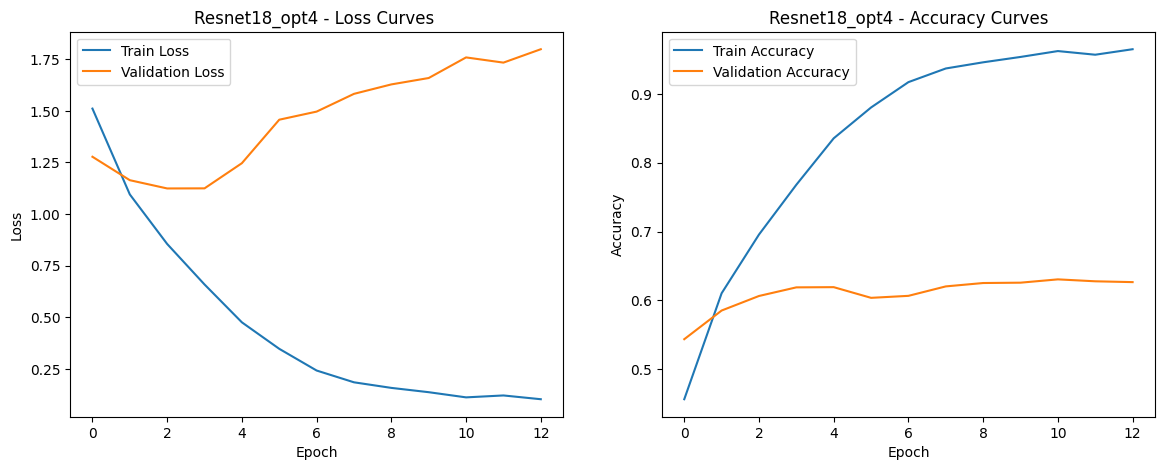

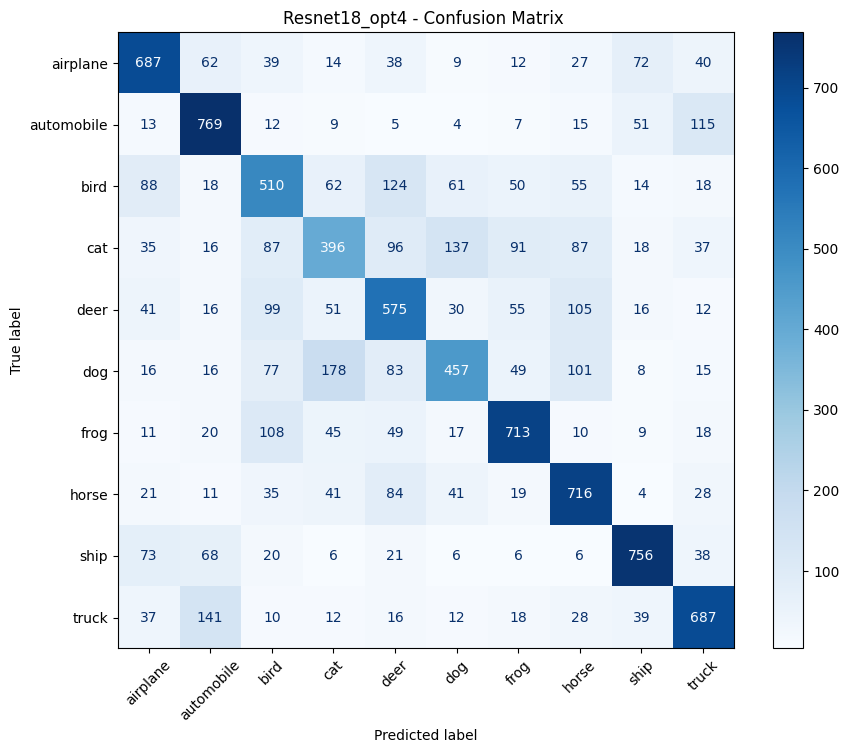

In [31]:
# Loss and accuracy curves 
model_name = "Resnet18_opt4"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 

### ResNet18 model optimisation-5

In [32]:
# Define the augmentations method
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets with transformations
train_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)

# Split the training dataset into 80% training and 20% validation
train_indices_aug, val_indices_aug = train_test_split(
    range(len(train_dataset_aug)),
    test_size=0.2,
    stratify=[label for _, label in train_dataset_aug],
    random_state=42
)

train_subset_aug = Subset(train_dataset_aug, train_indices_aug)

In [36]:
# DataLoaders, edit batch size
train_loader_aug = DataLoader(train_subset_aug, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader_128 = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

# Hyperparameter tuning
model = ResNet18(num_classes=10)
train_dataset = train_loader_aug
val_dataset = val_loader_128
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L2"
regularization_strength=0.0000001
models = {}
model_name = "Resnet18_opt5"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 1.9334, Train Accuracy: 0.2892, Validation Loss: 1.5883, Validation Accuracy: 0.4220


Epoch 2/100, Train Loss: 1.7543, Train Accuracy: 0.3549, Validation Loss: 1.4578, Validation Accuracy: 0.4736


Epoch 3/100, Train Loss: 1.6698, Train Accuracy: 0.3959, Validation Loss: 1.3843, Validation Accuracy: 0.4984


Epoch 4/100, Train Loss: 1.6017, Train Accuracy: 0.4200, Validation Loss: 1.3469, Validation Accuracy: 0.5252


Epoch 5/100, Train Loss: 1.5600, Train Accuracy: 0.4366, Validation Loss: 1.3192, Validation Accuracy: 0.5325


Epoch 6/100, Train Loss: 1.5188, Train Accuracy: 0.4519, Validation Loss: 1.1795, Validation Accuracy: 0.5796


Epoch 7/100, Train Loss: 1.4890, Train Accuracy: 0.4634, Validation Loss: 1.1916, Validation Accuracy: 0.5727


Epoch 8/100, Train Loss: 1.4421, Train Accuracy: 0.4856, Validation Loss: 1.1275, Validation Accuracy: 0.6033


Epoch 9/100, Train Loss: 1.4177, Train Accuracy: 0.4922, Validation Loss: 1.1246, Validation Accuracy: 0.6098


Epoch 10/100, Train Loss: 1.4028, Train Accuracy: 0.4975, Validation Loss: 1.0926, Validation Accuracy: 0.6171


Epoch 11/100, Train Loss: 1.3754, Train Accuracy: 0.5099, Validation Loss: 1.0753, Validation Accuracy: 0.6144


Epoch 12/100, Train Loss: 1.3545, Train Accuracy: 0.5192, Validation Loss: 1.0161, Validation Accuracy: 0.6412


Epoch 13/100, Train Loss: 1.3344, Train Accuracy: 0.5271, Validation Loss: 0.9999, Validation Accuracy: 0.6432


Epoch 14/100, Train Loss: 1.3151, Train Accuracy: 0.5309, Validation Loss: 0.9983, Validation Accuracy: 0.6536


Epoch 15/100, Train Loss: 1.2923, Train Accuracy: 0.5436, Validation Loss: 0.9565, Validation Accuracy: 0.6578


Epoch 16/100, Train Loss: 1.2763, Train Accuracy: 0.5475, Validation Loss: 0.9869, Validation Accuracy: 0.6561


Epoch 17/100, Train Loss: 1.2660, Train Accuracy: 0.5526, Validation Loss: 0.9469, Validation Accuracy: 0.6698


Epoch 18/100, Train Loss: 1.2487, Train Accuracy: 0.5548, Validation Loss: 0.9975, Validation Accuracy: 0.6509


Epoch 19/100, Train Loss: 1.2315, Train Accuracy: 0.5668, Validation Loss: 0.9963, Validation Accuracy: 0.6615


Epoch 20/100, Train Loss: 1.2201, Train Accuracy: 0.5650, Validation Loss: 0.8982, Validation Accuracy: 0.6884


Epoch 21/100, Train Loss: 1.2142, Train Accuracy: 0.5706, Validation Loss: 0.9036, Validation Accuracy: 0.6799


Epoch 22/100, Train Loss: 1.1938, Train Accuracy: 0.5790, Validation Loss: 0.9388, Validation Accuracy: 0.6802


Epoch 23/100, Train Loss: 1.1888, Train Accuracy: 0.5808, Validation Loss: 0.8488, Validation Accuracy: 0.7060


Epoch 24/100, Train Loss: 1.1764, Train Accuracy: 0.5861, Validation Loss: 0.8635, Validation Accuracy: 0.6974


Epoch 25/100, Train Loss: 1.1725, Train Accuracy: 0.5837, Validation Loss: 0.8629, Validation Accuracy: 0.6993


Epoch 26/100, Train Loss: 1.1524, Train Accuracy: 0.5942, Validation Loss: 0.8333, Validation Accuracy: 0.7130


Epoch 27/100, Train Loss: 1.1546, Train Accuracy: 0.5951, Validation Loss: 0.8521, Validation Accuracy: 0.7058


Epoch 28/100, Train Loss: 1.1346, Train Accuracy: 0.5979, Validation Loss: 0.8064, Validation Accuracy: 0.7161


Epoch 29/100, Train Loss: 1.1266, Train Accuracy: 0.6008, Validation Loss: 0.8055, Validation Accuracy: 0.7217


Epoch 30/100, Train Loss: 1.1190, Train Accuracy: 0.6062, Validation Loss: 0.8068, Validation Accuracy: 0.7254


Epoch 31/100, Train Loss: 1.1094, Train Accuracy: 0.6104, Validation Loss: 0.7771, Validation Accuracy: 0.7286


Epoch 32/100, Train Loss: 1.1052, Train Accuracy: 0.6119, Validation Loss: 0.8251, Validation Accuracy: 0.7146


Epoch 33/100, Train Loss: 1.0952, Train Accuracy: 0.6139, Validation Loss: 0.7644, Validation Accuracy: 0.7337


Epoch 34/100, Train Loss: 1.0861, Train Accuracy: 0.6168, Validation Loss: 0.7666, Validation Accuracy: 0.7345


Epoch 35/100, Train Loss: 1.0776, Train Accuracy: 0.6218, Validation Loss: 0.7707, Validation Accuracy: 0.7322


Epoch 36/100, Train Loss: 1.0785, Train Accuracy: 0.6204, Validation Loss: 0.7466, Validation Accuracy: 0.7396


Epoch 37/100, Train Loss: 1.0706, Train Accuracy: 0.6248, Validation Loss: 0.7377, Validation Accuracy: 0.7418


Epoch 38/100, Train Loss: 1.0655, Train Accuracy: 0.6250, Validation Loss: 0.7546, Validation Accuracy: 0.7362


Epoch 39/100, Train Loss: 1.0549, Train Accuracy: 0.6309, Validation Loss: 0.7525, Validation Accuracy: 0.7388


Epoch 40/100, Train Loss: 1.0479, Train Accuracy: 0.6310, Validation Loss: 0.7740, Validation Accuracy: 0.7337


Epoch 41/100, Train Loss: 1.0415, Train Accuracy: 0.6364, Validation Loss: 0.7400, Validation Accuracy: 0.7414


Epoch 42/100, Train Loss: 1.0357, Train Accuracy: 0.6349, Validation Loss: 0.8054, Validation Accuracy: 0.7299


Epoch 43/100, Train Loss: 1.0318, Train Accuracy: 0.6372, Validation Loss: 0.7600, Validation Accuracy: 0.7369


Epoch 44/100, Train Loss: 1.0234, Train Accuracy: 0.6389, Validation Loss: 0.7262, Validation Accuracy: 0.7490


Epoch 45/100, Train Loss: 1.0147, Train Accuracy: 0.6462, Validation Loss: 0.7319, Validation Accuracy: 0.7513


Epoch 46/100, Train Loss: 1.0173, Train Accuracy: 0.6430, Validation Loss: 0.7319, Validation Accuracy: 0.7437


Epoch 47/100, Train Loss: 1.0075, Train Accuracy: 0.6441, Validation Loss: 0.7076, Validation Accuracy: 0.7536


Epoch 48/100, Train Loss: 0.9980, Train Accuracy: 0.6480, Validation Loss: 0.7315, Validation Accuracy: 0.7483


Epoch 49/100, Train Loss: 0.9970, Train Accuracy: 0.6482, Validation Loss: 0.7200, Validation Accuracy: 0.7547


Epoch 50/100, Train Loss: 1.0003, Train Accuracy: 0.6451, Validation Loss: 0.6858, Validation Accuracy: 0.7639


Epoch 51/100, Train Loss: 0.9860, Train Accuracy: 0.6525, Validation Loss: 0.7001, Validation Accuracy: 0.7602


Epoch 52/100, Train Loss: 0.9835, Train Accuracy: 0.6552, Validation Loss: 0.6787, Validation Accuracy: 0.7645


Epoch 53/100, Train Loss: 0.9777, Train Accuracy: 0.6592, Validation Loss: 0.7372, Validation Accuracy: 0.7457


Epoch 54/100, Train Loss: 0.9769, Train Accuracy: 0.6559, Validation Loss: 0.7129, Validation Accuracy: 0.7496


Epoch 55/100, Train Loss: 0.9724, Train Accuracy: 0.6606, Validation Loss: 0.6895, Validation Accuracy: 0.7609


Epoch 56/100, Train Loss: 0.9668, Train Accuracy: 0.6614, Validation Loss: 0.6909, Validation Accuracy: 0.7618


Epoch 57/100, Train Loss: 0.9594, Train Accuracy: 0.6612, Validation Loss: 0.7099, Validation Accuracy: 0.7618


Epoch 58/100, Train Loss: 0.9567, Train Accuracy: 0.6647, Validation Loss: 0.6832, Validation Accuracy: 0.7632


Epoch 59/100, Train Loss: 0.9514, Train Accuracy: 0.6673, Validation Loss: 0.6518, Validation Accuracy: 0.7764


Epoch 60/100, Train Loss: 0.9396, Train Accuracy: 0.6699, Validation Loss: 0.6765, Validation Accuracy: 0.7686


Epoch 61/100, Train Loss: 0.9478, Train Accuracy: 0.6642, Validation Loss: 0.7016, Validation Accuracy: 0.7656


Epoch 62/100, Train Loss: 0.9370, Train Accuracy: 0.6715, Validation Loss: 0.6603, Validation Accuracy: 0.7675


Epoch 63/100, Train Loss: 0.9330, Train Accuracy: 0.6743, Validation Loss: 0.6992, Validation Accuracy: 0.7634


Epoch 64/100, Train Loss: 0.9356, Train Accuracy: 0.6714, Validation Loss: 0.6469, Validation Accuracy: 0.7736


Epoch 65/100, Train Loss: 0.9321, Train Accuracy: 0.6739, Validation Loss: 0.6531, Validation Accuracy: 0.7735


Epoch 66/100, Train Loss: 0.9214, Train Accuracy: 0.6766, Validation Loss: 0.6334, Validation Accuracy: 0.7798


Epoch 67/100, Train Loss: 0.9166, Train Accuracy: 0.6791, Validation Loss: 0.7428, Validation Accuracy: 0.7525


Epoch 68/100, Train Loss: 0.9127, Train Accuracy: 0.6805, Validation Loss: 0.6461, Validation Accuracy: 0.7772


Epoch 69/100, Train Loss: 0.9216, Train Accuracy: 0.6768, Validation Loss: 0.6648, Validation Accuracy: 0.7736


Epoch 70/100, Train Loss: 0.9062, Train Accuracy: 0.6814, Validation Loss: 0.6595, Validation Accuracy: 0.7744


Epoch 71/100, Train Loss: 0.9107, Train Accuracy: 0.6806, Validation Loss: 0.6463, Validation Accuracy: 0.7790


Epoch 72/100, Train Loss: 0.8984, Train Accuracy: 0.6837, Validation Loss: 0.6619, Validation Accuracy: 0.7767


Epoch 73/100, Train Loss: 0.9024, Train Accuracy: 0.6804, Validation Loss: 0.6519, Validation Accuracy: 0.7796


Epoch 74/100, Train Loss: 0.8895, Train Accuracy: 0.6866, Validation Loss: 0.6616, Validation Accuracy: 0.7762


Epoch 75/100, Train Loss: 0.8964, Train Accuracy: 0.6858, Validation Loss: 0.6600, Validation Accuracy: 0.7737


Epoch 76/100, Train Loss: 0.8890, Train Accuracy: 0.6864, Validation Loss: 0.6741, Validation Accuracy: 0.7711
Early stopping...
Training complete. Final model saved at 'models/Resnet18_opt5.pth'


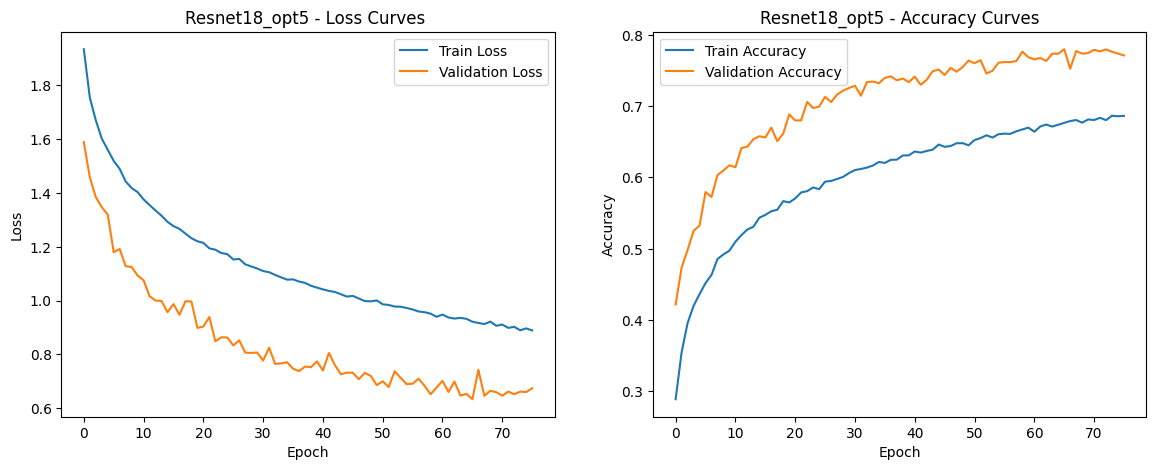

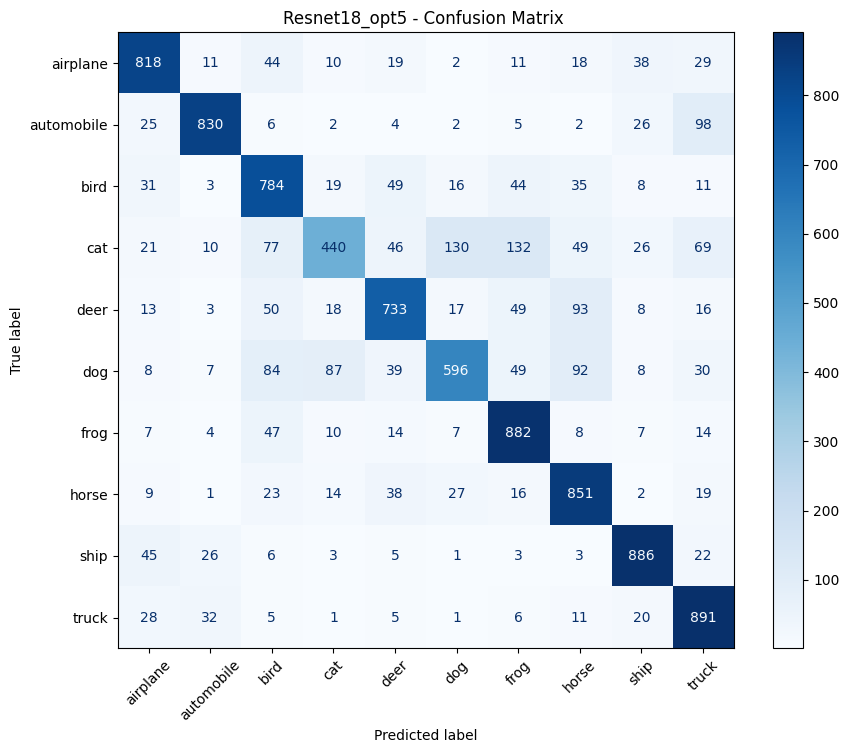

In [37]:
# Loss and accuracy curves 
model_name = "Resnet18_opt5"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 


### ResNet18 model optimisation-6

In [40]:
# Basic Block for ResNet18 without residual connections
class BasicBlockNoResidual(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlockNoResidual, self).__init__()
        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = F.relu(out)
        return out

# ResNet18 Architecture without residual links
class ResNet18_nores(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18_nores, self).__init__()
        self.in_channels = 64

        # Initial layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(BasicBlockNoResidual, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlockNoResidual, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlockNoResidual, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlockNoResidual, 512, 2, stride=2)

        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)  # First block may have stride != 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [41]:
# DataLoaders, edit batch size
train_loader_aug = DataLoader(train_subset_aug, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader_128 = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

# Hyperparameter tuning
model = ResNet18_nores(num_classes=10)
train_dataset = train_loader_aug
val_dataset = val_loader_128
optimizer=optim.Adam
learning_rate=0.001
epochs =100
patience=10
regularization="L2"
regularization_strength=0.000001
models = {}
model_name = "Resnet18_opt6"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 2.0110, Train Accuracy: 0.2241, Validation Loss: 1.8136, Validation Accuracy: 0.2961


Epoch 2/100, Train Loss: 1.8820, Train Accuracy: 0.2866, Validation Loss: 2.0328, Validation Accuracy: 0.2883


Epoch 3/100, Train Loss: 1.7988, Train Accuracy: 0.3218, Validation Loss: 1.6190, Validation Accuracy: 0.3629


Epoch 4/100, Train Loss: 1.7303, Train Accuracy: 0.3548, Validation Loss: 1.6182, Validation Accuracy: 0.4030


Epoch 5/100, Train Loss: 1.6769, Train Accuracy: 0.3808, Validation Loss: 1.5264, Validation Accuracy: 0.4260


Epoch 6/100, Train Loss: 1.6333, Train Accuracy: 0.4000, Validation Loss: 1.5771, Validation Accuracy: 0.4581


Epoch 7/100, Train Loss: 1.5937, Train Accuracy: 0.4261, Validation Loss: 1.3891, Validation Accuracy: 0.5035


Epoch 8/100, Train Loss: 1.5561, Train Accuracy: 0.4419, Validation Loss: 1.2940, Validation Accuracy: 0.5261


Epoch 9/100, Train Loss: 1.5196, Train Accuracy: 0.4592, Validation Loss: 1.2879, Validation Accuracy: 0.5466


Epoch 10/100, Train Loss: 1.4990, Train Accuracy: 0.4687, Validation Loss: 1.3019, Validation Accuracy: 0.5494


Epoch 11/100, Train Loss: 1.4662, Train Accuracy: 0.4824, Validation Loss: 1.1312, Validation Accuracy: 0.5981


Epoch 12/100, Train Loss: 1.4444, Train Accuracy: 0.4924, Validation Loss: 1.1990, Validation Accuracy: 0.5750


Epoch 13/100, Train Loss: 1.4160, Train Accuracy: 0.5034, Validation Loss: 1.4441, Validation Accuracy: 0.5212


Epoch 14/100, Train Loss: 1.4159, Train Accuracy: 0.5032, Validation Loss: 1.1146, Validation Accuracy: 0.6159


Epoch 15/100, Train Loss: 1.3894, Train Accuracy: 0.5135, Validation Loss: 1.1419, Validation Accuracy: 0.6043


Epoch 16/100, Train Loss: 1.3685, Train Accuracy: 0.5243, Validation Loss: 1.1808, Validation Accuracy: 0.5886


Epoch 17/100, Train Loss: 1.3589, Train Accuracy: 0.5295, Validation Loss: 1.1187, Validation Accuracy: 0.6094


Epoch 18/100, Train Loss: 1.3334, Train Accuracy: 0.5379, Validation Loss: 1.0591, Validation Accuracy: 0.6394


Epoch 19/100, Train Loss: 1.3241, Train Accuracy: 0.5410, Validation Loss: 0.9801, Validation Accuracy: 0.6607


Epoch 20/100, Train Loss: 1.3160, Train Accuracy: 0.5442, Validation Loss: 1.0058, Validation Accuracy: 0.6505


Epoch 21/100, Train Loss: 1.2967, Train Accuracy: 0.5525, Validation Loss: 1.0138, Validation Accuracy: 0.6522


Epoch 22/100, Train Loss: 1.3020, Train Accuracy: 0.5497, Validation Loss: 1.0353, Validation Accuracy: 0.6327


Epoch 23/100, Train Loss: 1.2861, Train Accuracy: 0.5566, Validation Loss: 0.9622, Validation Accuracy: 0.6754


Epoch 24/100, Train Loss: 1.2779, Train Accuracy: 0.5593, Validation Loss: 0.9035, Validation Accuracy: 0.6885


Epoch 25/100, Train Loss: 1.2652, Train Accuracy: 0.5623, Validation Loss: 0.9694, Validation Accuracy: 0.6693


Epoch 26/100, Train Loss: 1.2563, Train Accuracy: 0.5667, Validation Loss: 0.8607, Validation Accuracy: 0.7056


Epoch 27/100, Train Loss: 1.2528, Train Accuracy: 0.5686, Validation Loss: 0.9527, Validation Accuracy: 0.6711


Epoch 28/100, Train Loss: 1.2349, Train Accuracy: 0.5754, Validation Loss: 0.8792, Validation Accuracy: 0.6998


Epoch 29/100, Train Loss: 1.2325, Train Accuracy: 0.5761, Validation Loss: 0.9009, Validation Accuracy: 0.6978


Epoch 30/100, Train Loss: 1.2146, Train Accuracy: 0.5841, Validation Loss: 0.8844, Validation Accuracy: 0.6966


Epoch 31/100, Train Loss: 1.2211, Train Accuracy: 0.5830, Validation Loss: 0.8670, Validation Accuracy: 0.7093


Epoch 32/100, Train Loss: 1.2141, Train Accuracy: 0.5836, Validation Loss: 0.8236, Validation Accuracy: 0.7173


Epoch 33/100, Train Loss: 1.2003, Train Accuracy: 0.5892, Validation Loss: 0.8393, Validation Accuracy: 0.7153


Epoch 34/100, Train Loss: 1.2032, Train Accuracy: 0.5862, Validation Loss: 0.8450, Validation Accuracy: 0.7119


Epoch 35/100, Train Loss: 1.1897, Train Accuracy: 0.5910, Validation Loss: 0.7982, Validation Accuracy: 0.7310


Epoch 36/100, Train Loss: 1.1863, Train Accuracy: 0.5939, Validation Loss: 0.8268, Validation Accuracy: 0.7245


Epoch 37/100, Train Loss: 1.1825, Train Accuracy: 0.5953, Validation Loss: 0.8068, Validation Accuracy: 0.7310


Epoch 38/100, Train Loss: 1.1681, Train Accuracy: 0.6012, Validation Loss: 0.9275, Validation Accuracy: 0.6928


Epoch 39/100, Train Loss: 1.1676, Train Accuracy: 0.5985, Validation Loss: 0.8244, Validation Accuracy: 0.7254


Epoch 40/100, Train Loss: 1.1554, Train Accuracy: 0.6047, Validation Loss: 0.8192, Validation Accuracy: 0.7212


Epoch 41/100, Train Loss: 1.1481, Train Accuracy: 0.6072, Validation Loss: 0.8550, Validation Accuracy: 0.7127


Epoch 42/100, Train Loss: 1.1500, Train Accuracy: 0.6112, Validation Loss: 0.7920, Validation Accuracy: 0.7336


Epoch 43/100, Train Loss: 1.1477, Train Accuracy: 0.6072, Validation Loss: 0.7911, Validation Accuracy: 0.7327


Epoch 44/100, Train Loss: 1.1404, Train Accuracy: 0.6138, Validation Loss: 0.7723, Validation Accuracy: 0.7360


Epoch 45/100, Train Loss: 1.1404, Train Accuracy: 0.6135, Validation Loss: 0.8421, Validation Accuracy: 0.7160


Epoch 46/100, Train Loss: 1.1418, Train Accuracy: 0.6103, Validation Loss: 0.8424, Validation Accuracy: 0.7245


Epoch 47/100, Train Loss: 1.1312, Train Accuracy: 0.6142, Validation Loss: 0.8022, Validation Accuracy: 0.7362


Epoch 48/100, Train Loss: 1.1273, Train Accuracy: 0.6180, Validation Loss: 0.8089, Validation Accuracy: 0.7271


Epoch 49/100, Train Loss: 1.1249, Train Accuracy: 0.6184, Validation Loss: 0.7778, Validation Accuracy: 0.7388


Epoch 50/100, Train Loss: 1.1108, Train Accuracy: 0.6219, Validation Loss: 0.7387, Validation Accuracy: 0.7482


Epoch 51/100, Train Loss: 1.1219, Train Accuracy: 0.6185, Validation Loss: 0.9003, Validation Accuracy: 0.7111


Epoch 52/100, Train Loss: 1.1089, Train Accuracy: 0.6202, Validation Loss: 0.7734, Validation Accuracy: 0.7413


Epoch 53/100, Train Loss: 1.1131, Train Accuracy: 0.6226, Validation Loss: 0.7640, Validation Accuracy: 0.7427


Epoch 54/100, Train Loss: 1.1091, Train Accuracy: 0.6266, Validation Loss: 0.7395, Validation Accuracy: 0.7503


Epoch 55/100, Train Loss: 1.1030, Train Accuracy: 0.6247, Validation Loss: 0.7710, Validation Accuracy: 0.7427


Epoch 56/100, Train Loss: 1.0917, Train Accuracy: 0.6282, Validation Loss: 0.7394, Validation Accuracy: 0.7471


Epoch 57/100, Train Loss: 1.0875, Train Accuracy: 0.6322, Validation Loss: 0.7354, Validation Accuracy: 0.7559


Epoch 58/100, Train Loss: 1.0853, Train Accuracy: 0.6333, Validation Loss: 0.7240, Validation Accuracy: 0.7526


Epoch 59/100, Train Loss: 1.0912, Train Accuracy: 0.6303, Validation Loss: 0.7925, Validation Accuracy: 0.7399


Epoch 60/100, Train Loss: 1.0731, Train Accuracy: 0.6360, Validation Loss: 0.7389, Validation Accuracy: 0.7532


Epoch 61/100, Train Loss: 1.0779, Train Accuracy: 0.6339, Validation Loss: 0.7263, Validation Accuracy: 0.7571


Epoch 62/100, Train Loss: 1.0713, Train Accuracy: 0.6361, Validation Loss: 0.7522, Validation Accuracy: 0.7485


Epoch 63/100, Train Loss: 1.0759, Train Accuracy: 0.6338, Validation Loss: 0.7637, Validation Accuracy: 0.7508


Epoch 64/100, Train Loss: 1.0720, Train Accuracy: 0.6346, Validation Loss: 0.7263, Validation Accuracy: 0.7576


Epoch 65/100, Train Loss: 1.0575, Train Accuracy: 0.6390, Validation Loss: 0.7173, Validation Accuracy: 0.7619


Epoch 66/100, Train Loss: 1.0672, Train Accuracy: 0.6369, Validation Loss: 0.7456, Validation Accuracy: 0.7537


Epoch 67/100, Train Loss: 1.0580, Train Accuracy: 0.6421, Validation Loss: 0.7141, Validation Accuracy: 0.7624


Epoch 68/100, Train Loss: 1.0477, Train Accuracy: 0.6459, Validation Loss: 0.6978, Validation Accuracy: 0.7673


Epoch 69/100, Train Loss: 1.0536, Train Accuracy: 0.6417, Validation Loss: 0.6971, Validation Accuracy: 0.7663


Epoch 70/100, Train Loss: 1.0482, Train Accuracy: 0.6456, Validation Loss: 0.7053, Validation Accuracy: 0.7713


Epoch 71/100, Train Loss: 1.0562, Train Accuracy: 0.6427, Validation Loss: 0.7049, Validation Accuracy: 0.7654


Epoch 72/100, Train Loss: 1.0365, Train Accuracy: 0.6482, Validation Loss: 0.6996, Validation Accuracy: 0.7653


Epoch 73/100, Train Loss: 1.0570, Train Accuracy: 0.6414, Validation Loss: 0.6857, Validation Accuracy: 0.7684


Epoch 74/100, Train Loss: 1.0384, Train Accuracy: 0.6501, Validation Loss: 0.6904, Validation Accuracy: 0.7724


Epoch 75/100, Train Loss: 1.0423, Train Accuracy: 0.6486, Validation Loss: 0.6827, Validation Accuracy: 0.7679


Epoch 76/100, Train Loss: 1.0395, Train Accuracy: 0.6475, Validation Loss: 0.7232, Validation Accuracy: 0.7608


Epoch 77/100, Train Loss: 1.0331, Train Accuracy: 0.6521, Validation Loss: 0.7030, Validation Accuracy: 0.7654


Epoch 78/100, Train Loss: 1.0329, Train Accuracy: 0.6509, Validation Loss: 0.6941, Validation Accuracy: 0.7656


Epoch 79/100, Train Loss: 1.0370, Train Accuracy: 0.6479, Validation Loss: 0.6864, Validation Accuracy: 0.7748


Epoch 80/100, Train Loss: 1.0325, Train Accuracy: 0.6527, Validation Loss: 0.6824, Validation Accuracy: 0.7738


Epoch 81/100, Train Loss: 1.0255, Train Accuracy: 0.6513, Validation Loss: 0.7067, Validation Accuracy: 0.7630


Epoch 82/100, Train Loss: 1.0317, Train Accuracy: 0.6518, Validation Loss: 0.6752, Validation Accuracy: 0.7771


Epoch 83/100, Train Loss: 1.0197, Train Accuracy: 0.6567, Validation Loss: 0.6638, Validation Accuracy: 0.7740


Epoch 84/100, Train Loss: 1.0197, Train Accuracy: 0.6560, Validation Loss: 0.6816, Validation Accuracy: 0.7773


Epoch 85/100, Train Loss: 1.0225, Train Accuracy: 0.6550, Validation Loss: 0.6963, Validation Accuracy: 0.7662


Epoch 86/100, Train Loss: 1.0228, Train Accuracy: 0.6557, Validation Loss: 0.6954, Validation Accuracy: 0.7724


Epoch 87/100, Train Loss: 1.0178, Train Accuracy: 0.6587, Validation Loss: 0.6643, Validation Accuracy: 0.7762


Epoch 88/100, Train Loss: 1.0079, Train Accuracy: 0.6577, Validation Loss: 0.6596, Validation Accuracy: 0.7799


Epoch 89/100, Train Loss: 1.0119, Train Accuracy: 0.6594, Validation Loss: 0.7174, Validation Accuracy: 0.7650


Epoch 90/100, Train Loss: 1.0126, Train Accuracy: 0.6574, Validation Loss: 0.7110, Validation Accuracy: 0.7634


Epoch 91/100, Train Loss: 1.0078, Train Accuracy: 0.6607, Validation Loss: 0.6862, Validation Accuracy: 0.7728


Epoch 92/100, Train Loss: 1.0045, Train Accuracy: 0.6619, Validation Loss: 0.6512, Validation Accuracy: 0.7848


Epoch 93/100, Train Loss: 1.0140, Train Accuracy: 0.6567, Validation Loss: 0.6970, Validation Accuracy: 0.7646


Epoch 94/100, Train Loss: 1.0016, Train Accuracy: 0.6621, Validation Loss: 0.6582, Validation Accuracy: 0.7813


Epoch 95/100, Train Loss: 1.0073, Train Accuracy: 0.6612, Validation Loss: 0.6344, Validation Accuracy: 0.7849


Epoch 96/100, Train Loss: 0.9960, Train Accuracy: 0.6654, Validation Loss: 0.6440, Validation Accuracy: 0.7823


Epoch 97/100, Train Loss: 0.9962, Train Accuracy: 0.6638, Validation Loss: 0.6742, Validation Accuracy: 0.7775


Epoch 98/100, Train Loss: 0.9987, Train Accuracy: 0.6636, Validation Loss: 0.6747, Validation Accuracy: 0.7760


Epoch 99/100, Train Loss: 0.9894, Train Accuracy: 0.6667, Validation Loss: 0.6420, Validation Accuracy: 0.7892


Epoch 100/100, Train Loss: 0.9851, Train Accuracy: 0.6674, Validation Loss: 0.6346, Validation Accuracy: 0.7917
Training complete. Final model saved at 'models/Resnet18_opt6.pth'


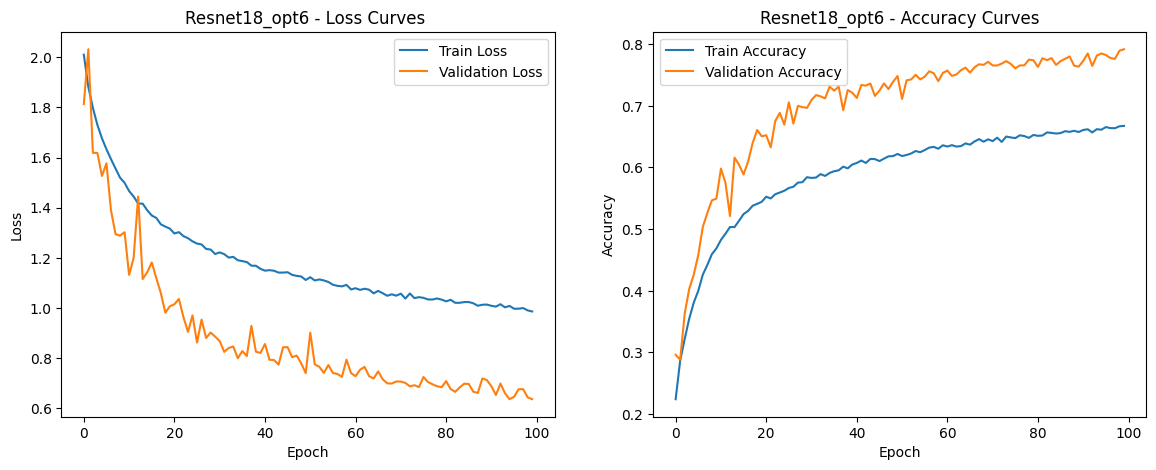

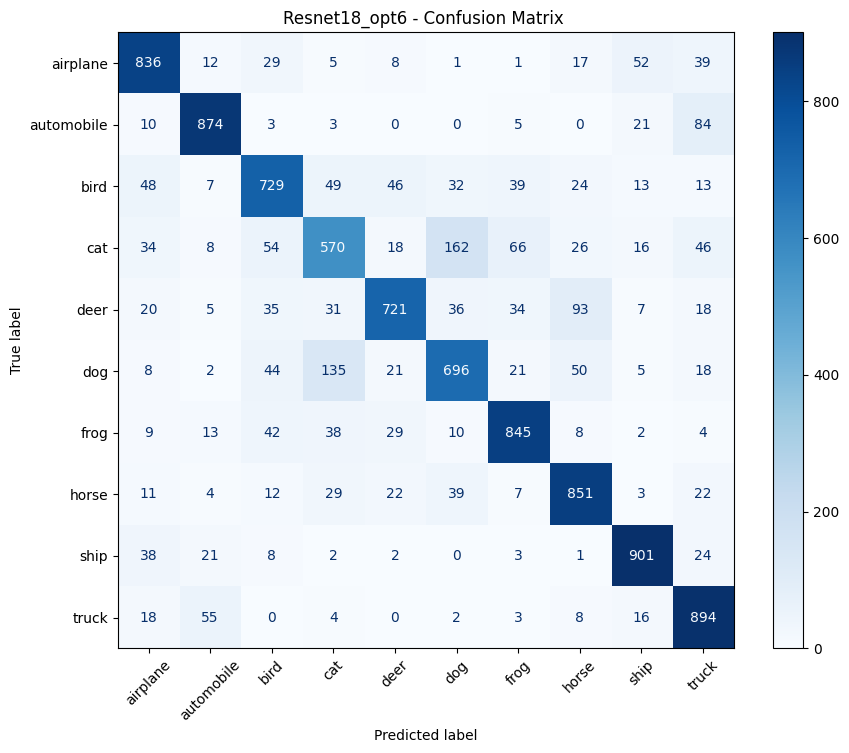

In [42]:
# Loss and accuracy curves 
model_name = "Resnet18_opt6"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 


### ResNet18 model optimisation-7

In [46]:
# DataLoaders, edit batch size
train_loader_aug = DataLoader(train_subset_aug, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader_128 = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

# Hyperparameter tuning
model = ResNet18(num_classes=10)
train_dataset = train_loader_aug
val_dataset = val_loader_128
optimizer=optim.NAdam
learning_rate=0.001
epochs =100
patience=10
regularization=None
regularization_strength=None
models = {}
model_name = "Resnet18_opt7"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 1.8860, Train Accuracy: 0.3089, Validation Loss: 1.6575, Validation Accuracy: 0.3980


Epoch 2/100, Train Loss: 1.6748, Train Accuracy: 0.3910, Validation Loss: 1.4748, Validation Accuracy: 0.4780


Epoch 3/100, Train Loss: 1.5825, Train Accuracy: 0.4335, Validation Loss: 1.4922, Validation Accuracy: 0.4919


Epoch 4/100, Train Loss: 1.4995, Train Accuracy: 0.4632, Validation Loss: 1.4087, Validation Accuracy: 0.5003


Epoch 5/100, Train Loss: 1.4373, Train Accuracy: 0.4894, Validation Loss: 1.1114, Validation Accuracy: 0.6075


Epoch 6/100, Train Loss: 1.3788, Train Accuracy: 0.5102, Validation Loss: 1.1951, Validation Accuracy: 0.5760


Epoch 7/100, Train Loss: 1.3414, Train Accuracy: 0.5199, Validation Loss: 1.0187, Validation Accuracy: 0.6446


Epoch 8/100, Train Loss: 1.2939, Train Accuracy: 0.5393, Validation Loss: 0.9778, Validation Accuracy: 0.6622


Epoch 9/100, Train Loss: 1.2721, Train Accuracy: 0.5502, Validation Loss: 0.9257, Validation Accuracy: 0.6807


Epoch 10/100, Train Loss: 1.2427, Train Accuracy: 0.5632, Validation Loss: 0.9350, Validation Accuracy: 0.6739


Epoch 11/100, Train Loss: 1.2185, Train Accuracy: 0.5708, Validation Loss: 0.8868, Validation Accuracy: 0.6934


Epoch 12/100, Train Loss: 1.1880, Train Accuracy: 0.5824, Validation Loss: 0.9451, Validation Accuracy: 0.6763


Epoch 13/100, Train Loss: 1.1734, Train Accuracy: 0.5878, Validation Loss: 0.8405, Validation Accuracy: 0.7087


Epoch 14/100, Train Loss: 1.1474, Train Accuracy: 0.5982, Validation Loss: 0.8375, Validation Accuracy: 0.7177


Epoch 15/100, Train Loss: 1.1411, Train Accuracy: 0.5992, Validation Loss: 0.7792, Validation Accuracy: 0.7292


Epoch 16/100, Train Loss: 1.1184, Train Accuracy: 0.6105, Validation Loss: 0.7852, Validation Accuracy: 0.7268


Epoch 17/100, Train Loss: 1.1057, Train Accuracy: 0.6135, Validation Loss: 0.7843, Validation Accuracy: 0.7330


Epoch 18/100, Train Loss: 1.0898, Train Accuracy: 0.6190, Validation Loss: 0.7665, Validation Accuracy: 0.7385


Epoch 19/100, Train Loss: 1.0767, Train Accuracy: 0.6226, Validation Loss: 0.8140, Validation Accuracy: 0.7237


Epoch 20/100, Train Loss: 1.0683, Train Accuracy: 0.6267, Validation Loss: 0.7518, Validation Accuracy: 0.7430


Epoch 21/100, Train Loss: 1.0622, Train Accuracy: 0.6315, Validation Loss: 0.8111, Validation Accuracy: 0.7217


Epoch 22/100, Train Loss: 1.0444, Train Accuracy: 0.6368, Validation Loss: 0.7237, Validation Accuracy: 0.7503


Epoch 23/100, Train Loss: 1.0395, Train Accuracy: 0.6363, Validation Loss: 0.6943, Validation Accuracy: 0.7642


Epoch 24/100, Train Loss: 1.0273, Train Accuracy: 0.6410, Validation Loss: 0.7003, Validation Accuracy: 0.7613


Epoch 25/100, Train Loss: 1.0230, Train Accuracy: 0.6420, Validation Loss: 0.7482, Validation Accuracy: 0.7435


Epoch 26/100, Train Loss: 1.0091, Train Accuracy: 0.6457, Validation Loss: 0.7140, Validation Accuracy: 0.7542


Epoch 27/100, Train Loss: 1.0038, Train Accuracy: 0.6495, Validation Loss: 0.6751, Validation Accuracy: 0.7672


Epoch 28/100, Train Loss: 0.9917, Train Accuracy: 0.6550, Validation Loss: 0.7606, Validation Accuracy: 0.7469


Epoch 29/100, Train Loss: 0.9836, Train Accuracy: 0.6561, Validation Loss: 0.6597, Validation Accuracy: 0.7702


Epoch 30/100, Train Loss: 0.9726, Train Accuracy: 0.6638, Validation Loss: 0.6733, Validation Accuracy: 0.7716


Epoch 31/100, Train Loss: 0.9738, Train Accuracy: 0.6574, Validation Loss: 0.7232, Validation Accuracy: 0.7573


Epoch 32/100, Train Loss: 0.9654, Train Accuracy: 0.6622, Validation Loss: 0.6640, Validation Accuracy: 0.7731


Epoch 33/100, Train Loss: 0.9615, Train Accuracy: 0.6630, Validation Loss: 0.6536, Validation Accuracy: 0.7765


Epoch 34/100, Train Loss: 0.9554, Train Accuracy: 0.6669, Validation Loss: 0.6738, Validation Accuracy: 0.7708


Epoch 35/100, Train Loss: 0.9402, Train Accuracy: 0.6731, Validation Loss: 0.6231, Validation Accuracy: 0.7855


Epoch 36/100, Train Loss: 0.9369, Train Accuracy: 0.6724, Validation Loss: 0.6255, Validation Accuracy: 0.7840


Epoch 37/100, Train Loss: 0.9339, Train Accuracy: 0.6758, Validation Loss: 0.6366, Validation Accuracy: 0.7836


Epoch 38/100, Train Loss: 0.9248, Train Accuracy: 0.6807, Validation Loss: 0.6594, Validation Accuracy: 0.7760


Epoch 39/100, Train Loss: 0.9221, Train Accuracy: 0.6804, Validation Loss: 0.6371, Validation Accuracy: 0.7848


Epoch 40/100, Train Loss: 0.9241, Train Accuracy: 0.6796, Validation Loss: 0.7190, Validation Accuracy: 0.7565


Epoch 41/100, Train Loss: 0.9144, Train Accuracy: 0.6786, Validation Loss: 0.6204, Validation Accuracy: 0.7918


Epoch 42/100, Train Loss: 0.9086, Train Accuracy: 0.6832, Validation Loss: 0.6261, Validation Accuracy: 0.7890


Epoch 43/100, Train Loss: 0.9020, Train Accuracy: 0.6858, Validation Loss: 0.6013, Validation Accuracy: 0.7945


Epoch 44/100, Train Loss: 0.8982, Train Accuracy: 0.6874, Validation Loss: 0.6104, Validation Accuracy: 0.7939


Epoch 45/100, Train Loss: 0.8987, Train Accuracy: 0.6864, Validation Loss: 0.6287, Validation Accuracy: 0.7884


Epoch 46/100, Train Loss: 0.8824, Train Accuracy: 0.6925, Validation Loss: 0.6207, Validation Accuracy: 0.7920


Epoch 47/100, Train Loss: 0.8846, Train Accuracy: 0.6906, Validation Loss: 0.6587, Validation Accuracy: 0.7791


Epoch 48/100, Train Loss: 0.8784, Train Accuracy: 0.6925, Validation Loss: 0.5958, Validation Accuracy: 0.7973


Epoch 49/100, Train Loss: 0.8730, Train Accuracy: 0.6952, Validation Loss: 0.6032, Validation Accuracy: 0.7953


Epoch 50/100, Train Loss: 0.8760, Train Accuracy: 0.6967, Validation Loss: 0.5850, Validation Accuracy: 0.8023


Epoch 51/100, Train Loss: 0.8755, Train Accuracy: 0.6953, Validation Loss: 0.6297, Validation Accuracy: 0.7905


Epoch 52/100, Train Loss: 0.8597, Train Accuracy: 0.7022, Validation Loss: 0.5782, Validation Accuracy: 0.8028


Epoch 53/100, Train Loss: 0.8568, Train Accuracy: 0.7002, Validation Loss: 0.5881, Validation Accuracy: 0.8006


Epoch 54/100, Train Loss: 0.8578, Train Accuracy: 0.7020, Validation Loss: 0.5829, Validation Accuracy: 0.7983


Epoch 55/100, Train Loss: 0.8572, Train Accuracy: 0.7023, Validation Loss: 0.6072, Validation Accuracy: 0.7962


Epoch 56/100, Train Loss: 0.8458, Train Accuracy: 0.7054, Validation Loss: 0.5941, Validation Accuracy: 0.7990


Epoch 57/100, Train Loss: 0.8454, Train Accuracy: 0.7047, Validation Loss: 0.5912, Validation Accuracy: 0.7994


Epoch 58/100, Train Loss: 0.8491, Train Accuracy: 0.7040, Validation Loss: 0.5701, Validation Accuracy: 0.8074


Epoch 59/100, Train Loss: 0.8417, Train Accuracy: 0.7054, Validation Loss: 0.5770, Validation Accuracy: 0.8045


Epoch 60/100, Train Loss: 0.8383, Train Accuracy: 0.7076, Validation Loss: 0.5571, Validation Accuracy: 0.8094


Epoch 61/100, Train Loss: 0.8256, Train Accuracy: 0.7120, Validation Loss: 0.5587, Validation Accuracy: 0.8070


Epoch 62/100, Train Loss: 0.8290, Train Accuracy: 0.7078, Validation Loss: 0.5740, Validation Accuracy: 0.8051


Epoch 63/100, Train Loss: 0.8239, Train Accuracy: 0.7106, Validation Loss: 0.5701, Validation Accuracy: 0.8057


Epoch 64/100, Train Loss: 0.8224, Train Accuracy: 0.7116, Validation Loss: 0.5451, Validation Accuracy: 0.8104


Epoch 65/100, Train Loss: 0.8195, Train Accuracy: 0.7138, Validation Loss: 0.6074, Validation Accuracy: 0.7983


Epoch 66/100, Train Loss: 0.8201, Train Accuracy: 0.7127, Validation Loss: 0.5502, Validation Accuracy: 0.8169


Epoch 67/100, Train Loss: 0.8194, Train Accuracy: 0.7120, Validation Loss: 0.5417, Validation Accuracy: 0.8169


Epoch 68/100, Train Loss: 0.8208, Train Accuracy: 0.7126, Validation Loss: 0.5747, Validation Accuracy: 0.8101


Epoch 69/100, Train Loss: 0.8068, Train Accuracy: 0.7179, Validation Loss: 0.5772, Validation Accuracy: 0.8089


Epoch 70/100, Train Loss: 0.8210, Train Accuracy: 0.7129, Validation Loss: 0.5574, Validation Accuracy: 0.8150


Epoch 71/100, Train Loss: 0.8042, Train Accuracy: 0.7184, Validation Loss: 0.5666, Validation Accuracy: 0.8154


Epoch 72/100, Train Loss: 0.8032, Train Accuracy: 0.7194, Validation Loss: 0.5902, Validation Accuracy: 0.8008


Epoch 73/100, Train Loss: 0.7990, Train Accuracy: 0.7219, Validation Loss: 0.5576, Validation Accuracy: 0.8124


Epoch 74/100, Train Loss: 0.8018, Train Accuracy: 0.7192, Validation Loss: 0.5676, Validation Accuracy: 0.8089


Epoch 75/100, Train Loss: 0.7898, Train Accuracy: 0.7246, Validation Loss: 0.5507, Validation Accuracy: 0.8182


Epoch 76/100, Train Loss: 0.7888, Train Accuracy: 0.7278, Validation Loss: 0.5723, Validation Accuracy: 0.8124


Epoch 77/100, Train Loss: 0.7827, Train Accuracy: 0.7275, Validation Loss: 0.5355, Validation Accuracy: 0.8220


Epoch 78/100, Train Loss: 0.7880, Train Accuracy: 0.7247, Validation Loss: 0.5728, Validation Accuracy: 0.8143


Epoch 79/100, Train Loss: 0.7880, Train Accuracy: 0.7244, Validation Loss: 0.5674, Validation Accuracy: 0.8149


Epoch 80/100, Train Loss: 0.7777, Train Accuracy: 0.7277, Validation Loss: 0.5646, Validation Accuracy: 0.8093


Epoch 81/100, Train Loss: 0.7826, Train Accuracy: 0.7234, Validation Loss: 0.5780, Validation Accuracy: 0.8156


Epoch 82/100, Train Loss: 0.7776, Train Accuracy: 0.7281, Validation Loss: 0.5479, Validation Accuracy: 0.8162


Epoch 83/100, Train Loss: 0.7856, Train Accuracy: 0.7250, Validation Loss: 0.5389, Validation Accuracy: 0.8203


Epoch 84/100, Train Loss: 0.7785, Train Accuracy: 0.7292, Validation Loss: 0.5579, Validation Accuracy: 0.8162


Epoch 85/100, Train Loss: 0.7734, Train Accuracy: 0.7285, Validation Loss: 0.5589, Validation Accuracy: 0.8144


Epoch 86/100, Train Loss: 0.7589, Train Accuracy: 0.7331, Validation Loss: 0.5503, Validation Accuracy: 0.8195


Epoch 87/100, Train Loss: 0.7659, Train Accuracy: 0.7314, Validation Loss: 0.5465, Validation Accuracy: 0.8179
Early stopping...
Training complete. Final model saved at 'models/Resnet18_opt7.pth'


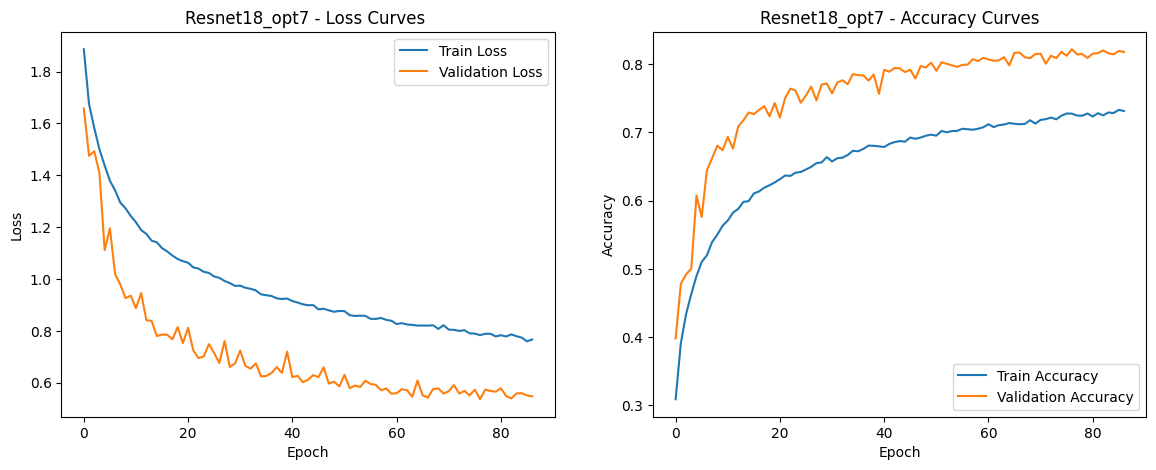

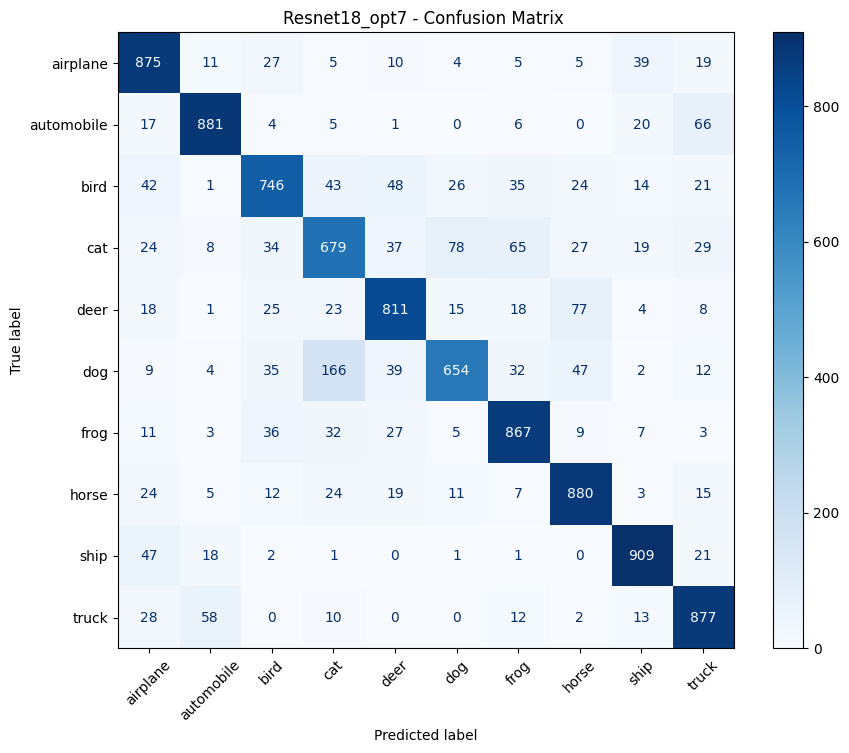

In [48]:
# Loss and accuracy curves 
model_name = "Resnet18_opt7"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 


### Comparing models

Resnet18_base Accuracy: 0.7427
Resnet18_opt1 Accuracy: 0.5890
Resnet18_opt2 Accuracy: 0.5989
Resnet18_opt3 Accuracy: 0.5832
Resnet18_opt4 Accuracy: 0.6306
Resnet18_opt5 Accuracy: 0.7798
Resnet18_opt6 Accuracy: 0.7917
Resnet18_opt7 Accuracy: 0.8220


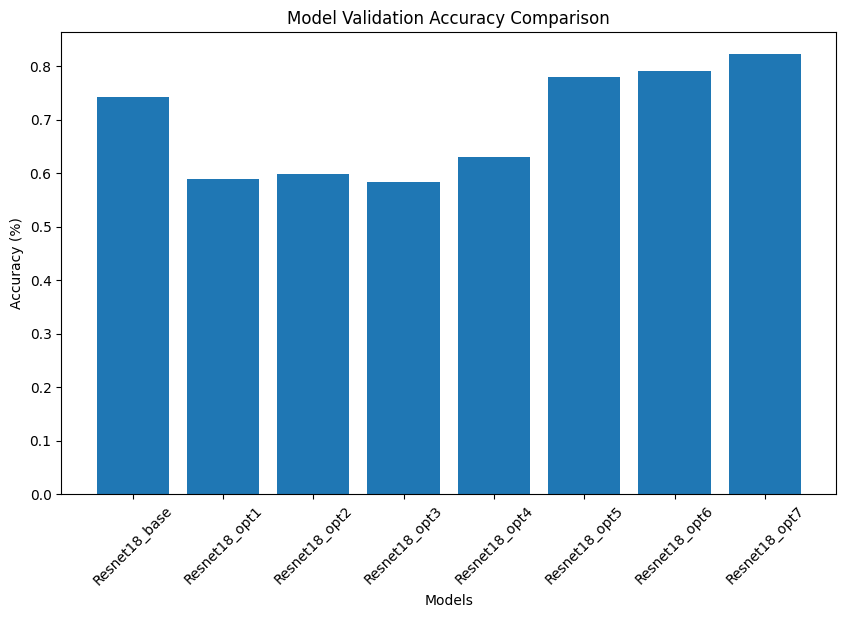

In [51]:
#Define the accuracy values

Resnet18_base_val_acc = 0.7427
Resnet18_opt1_val_acc = 0.5890
Resnet18_opt2_val_acc = 0.5989
Resnet18_opt3_val_acc = 0.5832
Resnet18_opt4_val_acc = 0.6306
Resnet18_opt5_val_acc = 0.7798
Resnet18_opt6_val_acc = 0.7917
Resnet18_opt7_val_acc = 0.8220


model_accuracies = {
    "Resnet18_base": Resnet18_base_val_acc,
    "Resnet18_opt1": Resnet18_opt1_val_acc,
    "Resnet18_opt2": Resnet18_opt2_val_acc,
    "Resnet18_opt3": Resnet18_opt3_val_acc,
    "Resnet18_opt4": Resnet18_opt4_val_acc,
    "Resnet18_opt5": Resnet18_opt5_val_acc,
    "Resnet18_opt6": Resnet18_opt6_val_acc,
    "Resnet18_opt7": Resnet18_opt7_val_acc,
}

# Print each model's accuracy
for model_name, accuracy in model_accuracies.items():
    print(f"{model_name} Accuracy: {accuracy:.4f}")

# Plotting the accuracies using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.title("Model Validation Accuracy Comparison")
plt.show()


### Evaluate to test dataset

D:\Users\a1913327\AppData\Local\Temp\2\ipykernel_17044\3644892545.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/Resnet18_opt7

Test Loss: 0.5469
Test Accuracy: 82.01%


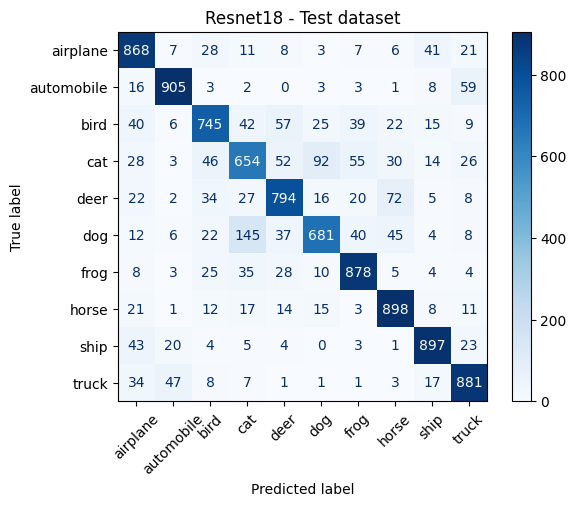

In [63]:
# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Re-instantiate your model architecture
# Replace `YourModelClass` with the actual class name of your model
model = ResNet18()
model.to(device)

# Load the model state_dict
model.load_state_dict(torch.load('models/Resnet18_opt7.pth'))
model.eval()

# Define the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

# Initialize variables to store metrics
test_loss = 0
correct = 0
total = 0
all_labels = []
all_predictions = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item() * labels.size(0)  # Accumulate loss
        
        # Get predicted classes
        _, predicted = torch.max(outputs, 1)
        
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store predictions and labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate average loss and accuracy
average_loss = test_loss / total
accuracy = 100 * correct / total

print(f'Test Loss: {average_loss:.4f}')
print(f'Test Accuracy: {accuracy:.2f}%')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Blues')
plt.plot(figsize=(8,8))
plt.xticks(rotation=45)
plt.title('Resnet18 - Test dataset')
plt.show()

